In [1]:
!nvidia-smi

Sat Dec  5 07:36:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu >> /dev/null
!pip install --upgrade grpcio >> /dev/null
!pip install tqdm >> /dev/null
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null

In [3]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np
import re

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# rcParams['figure.figsize'] = 12, 8

# RANDOM_SEED = 42

# np.random.seed(RANDOM_SEED)
# tf.random.set_seed(RANDOM_SEED)

In [4]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
os.makedirs("model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model

bert_model_name="uncased_L-12_H-768_A-12"

bert_dir = os.path.join("model/", bert_model_name)
bert_file = os.path.join(bert_dir, "bert_model.ckpt")
bert_config = os.path.join(bert_dir, "bert_config.json")


--2020-12-05 07:37:34--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   213MB/s    in 1.8s    

2020-12-05 07:37:36 (213 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [5]:
train = pd.read_json("sample_data/train.jsonl",lines=True)
#valid = pd.read_json("sample_data/valid.jsonl",lines=True)
test = pd.read_json("sample_data/test.jsonl",lines=True)

#train = train.append(valid).reset_index(drop=True)

In [6]:

def clean_text(text):
    text = str(text).lower()
    return text;
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    # text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"<url>", "", text)
    text = re.sub(r"@user", "", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

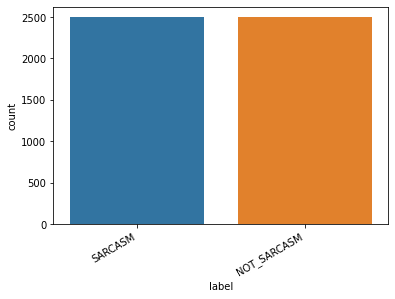

In [7]:
dataCategoriesChart = sns.countplot(x=train.label)
dataCategoriesChart.set_xticklabels(dataCategoriesChart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [8]:
class ScarcasmDetectionData:
  DATACOL = "response"
  LABELCOL = "label"

  def __init__(self, train, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train_data = train.reindex(train[ScarcasmDetectionData.DATACOL].str.len().sort_values().index)
    
    train_x, train_y = self._prepare(train_data)

    self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(train_x,
                                   train_y, random_state=0, test_size=0.1, shuffle=False)

    print("max seq_len", self.max_seq_len)
    print("size of train", len(self.train_x))
    print("size of test", len(self.test_x))
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[ScarcasmDetectionData.DATACOL], row[ScarcasmDetectionData.LABELCOL]
      tokens = self.tokenizer.tokenize(clean_text(text))
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [9]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_dir, "vocab.txt"))

In [10]:
def create_model(max_seq_len, bert_file):

  with tf.io.gfile.GFile(bert_config, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_file)
        
  return model

In [11]:
classes = train.label.unique().tolist()
data = ScarcasmDetectionData(train, tokenizer, classes, max_seq_len=128)


5000it [00:02, 1921.37it/s]


max seq_len 92
size of train 4500
size of test 500


In [12]:
model = create_model(data.max_seq_len, bert_file)

bert shape (None, 92, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f575db99a58> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [13]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [14]:
modelTrained = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.2,
  batch_size=8,
  shuffle=True,
  epochs=15
)

Epoch 1/15
450/450 [==============================] - 159s 354ms/step - loss: 0.6145 - acc: 0.6700 - val_loss: 0.5540 - val_acc: 0.7344
Epoch 2/15
450/450 [==============================] - 160s 355ms/step - loss: 0.5288 - acc: 0.7694 - val_loss: 0.5436 - val_acc: 0.7611
Epoch 3/15
450/450 [==============================] - 162s 361ms/step - loss: 0.4826 - acc: 0.8222 - val_loss: 0.5405 - val_acc: 0.7633
Epoch 4/15
450/450 [==============================] - 163s 363ms/step - loss: 0.4446 - acc: 0.8658 - val_loss: 0.5349 - val_acc: 0.7700
Epoch 5/15
450/450 [==============================] - 162s 361ms/step - loss: 0.4180 - acc: 0.8914 - val_loss: 0.5292 - val_acc: 0.7800
Epoch 6/15
450/450 [==============================] - 163s 362ms/step - loss: 0.4042 - acc: 0.9083 - val_loss: 0.5437 - val_acc: 0.7633
Epoch 7/15
450/450 [==============================] - 163s 363ms/step - loss: 0.3920 - acc: 0.9197 - val_loss: 0.5340 - val_acc: 0.7744
Epoch 8/15
450/450 [============================

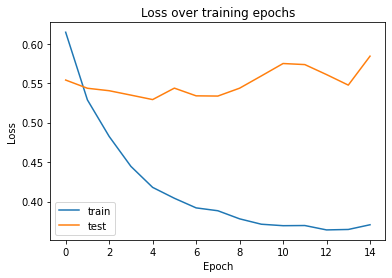

In [15]:
gca = plt.figure().gca()
gca.xaxis.set_major_locator(MaxNLocator(integer=True))
gca.plot(modelTrained.history['loss'])
gca.plot(modelTrained.history['val_loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

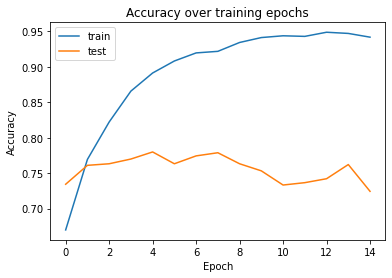

In [16]:
gca = plt.figure().gca()
gca.xaxis.set_major_locator(MaxNLocator(integer=True))
gca.plot(modelTrained.history['acc'])
gca.plot(modelTrained.history['val_acc'])

plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [17]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

sentences = list(test.response)
y_pred = model.predict(data.test_x).argmax(axis=-1)

16/16 [==============================] - 4s 223ms/step - loss: 0.6807 - acc: 0.6320
train acc 0.9102222323417664
test acc 0.6320000290870667


In [18]:
print(classification_report(data.test_y, y_pred, target_names=classes))

              precision    recall  f1-score   support

     SARCASM       0.45      0.90      0.60       155
 NOT_SARCASM       0.92      0.51      0.66       345

    accuracy                           0.63       500
   macro avg       0.69      0.71      0.63       500
weighted avg       0.78      0.63      0.64       500



In [19]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)


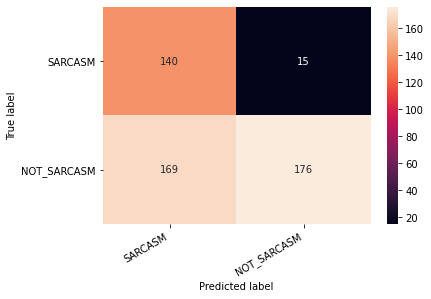

In [20]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [21]:
sentences = [
  "You just broke my car window. Great job.",
  "I sprayed perfume in my eye! I am now a genius",
  "I was depressed. He asked me to be happy. I am not depressed anymore."
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nsarcastic:", classes[label])
  print()

text: You just broke my car window. Great job. 
sarcastic: SARCASM

text: I sprayed perfume in my eye! I am now a genius 
sarcastic: SARCASM

text: I was depressed. He asked me to be happy. I am not depressed anymore. 
sarcastic: NOT_SARCASM



In [22]:
sentences = list(map(clean_text, test.response))
ids = list(test.id)
pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

In [23]:
for text, label, id in zip(sentences, predictions, ids):
  print('{0},{1}'.format(id, classes[label]))

twitter_1,NOT_SARCASM
twitter_2,SARCASM
twitter_3,SARCASM
twitter_4,SARCASM
twitter_5,SARCASM
twitter_6,SARCASM
twitter_7,NOT_SARCASM
twitter_8,SARCASM
twitter_9,SARCASM
twitter_10,SARCASM
twitter_11,SARCASM
twitter_12,SARCASM
twitter_13,NOT_SARCASM
twitter_14,NOT_SARCASM
twitter_15,SARCASM
twitter_16,NOT_SARCASM
twitter_17,SARCASM
twitter_18,SARCASM
twitter_19,SARCASM
twitter_20,NOT_SARCASM
twitter_21,NOT_SARCASM
twitter_22,SARCASM
twitter_23,NOT_SARCASM
twitter_24,SARCASM
twitter_25,SARCASM
twitter_26,SARCASM
twitter_27,SARCASM
twitter_28,NOT_SARCASM
twitter_29,SARCASM
twitter_30,SARCASM
twitter_31,SARCASM
twitter_32,NOT_SARCASM
twitter_33,NOT_SARCASM
twitter_34,SARCASM
twitter_35,SARCASM
twitter_36,SARCASM
twitter_37,SARCASM
twitter_38,SARCASM
twitter_39,SARCASM
twitter_40,NOT_SARCASM
twitter_41,SARCASM
twitter_42,NOT_SARCASM
twitter_43,SARCASM
twitter_44,NOT_SARCASM
twitter_45,SARCASM
twitter_46,NOT_SARCASM
twitter_47,SARCASM
twitter_48,SARCASM
twitter_49,NOT_SARCASM
twitter_50,SAR